## 第18章 用Keras实现图像识别
图像识别是深度学习中的重要内容，而卷积神经网络是目前解决这类问题的有效算法。具体实现可以使用PyTorch深度学习框架，也可以使用Keras框架或TensorFlow等。  
上章介绍了Keras的基础知识，利用keras作为深度学习平台，比较容易上手，其功能也很强大，本书最后3章将使用Keras实现一些深度学习任务。由于数据较大、算法参数较多建议有条件的同学使用GPU，当然CPU也可以，只是时间可能要长一些。  
Keras能自动判断使用GPU还是CPU，如果有GPU环境则使用GPU，否则使用CPU，程序或语法上没有区别。当然也可显式指定使用GPU或CPU。

### 18.1实例1：用自定义模型识别手写数字
这节我们用Keras构建神经网络来识别手写数据，使用MNIST数据集。这个数据集前面已介绍，<mark style=background-color:yellow>这个数据集用Keras的内置函数mnist直接装载。  
</mark>  
#### 18.1.1导入数据集，并初步探索数据集
（1）利用mnist模块直接装载数据集。

In [1]:
#在Keras地自带数据集中导入所需的MNIST模块
from keras.datasets import mnist
import keras

#加载数据到Keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


（2）完成数据集的加载后，我们来初步探索一下这个数据集。

Training Data Set shape:  (60000, 28, 28)
Training Data Set shape:  (10000, 28, 28)


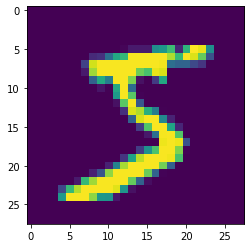

In [2]:
#查看数据集的形状
print("Training Data Set shape: ", x_train.shape)
print("Training Data Set shape: ", x_test.shape)

#初步可视化图片可以帮助我们建立直观的感受，这里使用索引0只打印了训练集和测试集的首张图片。
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(x_train[0])

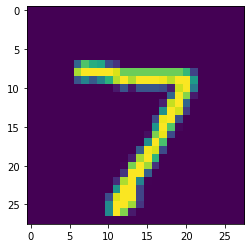

In [3]:
plt.imshow(x_test[0])

#### 18.1.2 数据预处理
在进行模型训练前，需要对数据进行预处理  
（1） 改变原数据的形状  
一张RGB格式的彩色图片会有三个通道(channel), 也就是图片深度(depth)为3。而我们现在要处理的图片是灰度图片，只有一个通道，深度为1。我们这里使用的是Tensorflow作为后台程序(backend), 所以，我们要处理的数据集需要由（n, width, height）转换成(n, width, height, depth)。

In [4]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

注意，如果后台程序是Theano，则目标数据集的维度应该是(n, depth, width, height)；为了避免这种情况，我们通常先确定通道(channel)的位置，然后根据确定的位置信息来转换数据集，以下代码完成了这一灵活转换。

In [5]:
# 定义输入图像数据的行列信息
img_rows, img_cols = 28, 28

#导入backend模块，使用函数image_data_format()获取通道位置信息
from keras import backend as K
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

（2）对数据进展规范化

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

（3）标签数据的预处理。

In [7]:
#查看标签数据集的形状
print("Training data's label shape: ", y_train.shape)
print("Test data's label shape: ", y_test.shape)

#打印训练集标签的前十条
print("The first 10 labels for training: ", y_train[:10])

Training data's label shape:  (60000,)
Test data's label shape:  (10000,)
The first 10 labels for training:  [5 0 4 1 9 2 1 3 1 4]


（3）使用keras自带工具将标签数据转换成二值数据格式

In [8]:
# 使用keras自带工具将标签数据转换成二值数据格式，以方便模型训练
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#打印结果
print("Training data's label shape, after transformation: ", y_train.shape)
print("The first 3 labels for training, after transformation: \n", y_train[:3])

Training data's label shape, after transformation:  (60000, 10)
The first 3 labels for training, after transformation: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


#### 18.1.3 定义模型结构
我们可以定义神经网络的结构了，即定义神经层的层数，每一层的神经元数量以及神经元之间的连接方式。  
（1）使用序贯模型构建神经网络

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

（2）逐层构建网络

In [13]:
model = Sequential()#初始化序贯模型
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))#二维卷积层
model.add(Conv2D(64, (3, 3), activation='relu'))#二维卷积层
model.add(MaxPooling2D(pool_size=(2, 2)))#最大池化层
model.add(Dropout(0.25))#dropout层
model.add(Flatten())#Flatten层，把tensor转换成一维形式
model.add(Dense(128, activation='relu'))#定义全连接层
model.add(Dropout(0.5))#定义dropout层
model.add(Dense(10, activation='softmax'))#定义输出层
model.summary()#查看模型结构


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

#### 18.1.5 编译模型
我们将定义用于训练模型参数的损失函数，优化器，和评估矩阵。

In [14]:
#以下编译过程定义了交叉熵损失函数，Adadelta优化器（一种比Adagrad更健壮的优化器），并以精度作为训练和测试过程的评估。
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#### 18.1.6  训练模型

In [15]:
history=model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 13s 221us/step - loss: 0.2581 - accuracy: 0.9223 - val_loss: 0.0563 - val_accuracy: 0.9830
Epoch 2/12
60000/60000 [==============================] - 11s 184us/step - loss: 0.0902 - accuracy: 0.9736 - val_loss: 0.0463 - val_accuracy: 0.9843
Epoch 3/12
60000/60000 [==============================] - 11s 185us/step - loss: 0.0676 - accuracy: 0.9795 - val_loss: 0.0336 - val_accuracy: 0.9888
Epoch 4/12
60000/60000 [==============================] - 11s 183us/step - loss: 0.0541 - accuracy: 0.9841 - val_loss: 0.0312 - val_accuracy: 0.9885
Epoch 5/12
60000/60000 [==============================] - 11s 183us/step - loss: 0.0484 - accuracy: 0.9861 - val_loss: 0.0311 - val_accuracy: 0.9887
Epoch 6/12
60000/60000 [==============================] - 11s 182us/step - loss: 0.0415 - accuracy: 0.9877 - val_loss: 0.0282 - val_accuracy: 0.9901
Epoch 7/12
60000/60000 [==============================] 

#### 18.1.7 模型评估

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.028370793479408893
Test accuracy: 0.9904000163078308


可视化训练过程

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


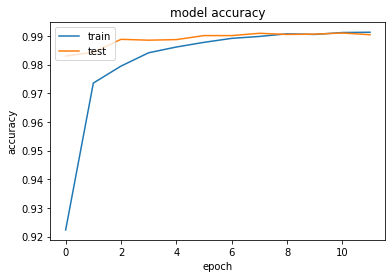

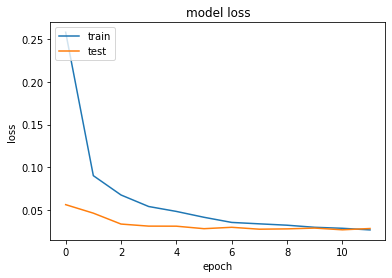

In [17]:
#使用matplotlib简单可视化
import matplotlib.pyplot as plt
# 列出history中的所有关键字
print(history.history.keys())
# 显示accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 显示loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 18.2 实例2：用预训练模型识别图像
<mark style=background-color:yellow>实例1我们自己构建神经网络，导入数据训练模型，然后对测试数据进行分类或预测。这是常用方法，此外，我们还可以借用别人训练好的模型，直接进行分类或预测。如何实现呢？本例将详细介绍。  
这里我们用一个在数据集ImageNet已训练好的一个模型（即预训练模型）来预测一个图片，输入图片是一只拉布拉多犬（Labrador），看这个预训练模型能否准备预测出来。</mark> 
#### 18.2.1 Keras中基于ImageNet的预训练模型
Keras中的keras.applications模块很多常见深度学习模型，这些模型的参数是在ImageNet数据集上训练好的（pre-trained weights）。我们可以直接使用这些模型做预测，也可以用来做特征提取，或者参数微调。  
（1）ImageNet数据集简介：  
ImageNet数据集是按照WordNet架构组织的大规模带标签图像数据集，大约1500万张图片，2万多分类，每张图片都经过严格的人工筛选与标记。  
（2）在ImageNet训练的模型很多，主要包括如下一些模型：
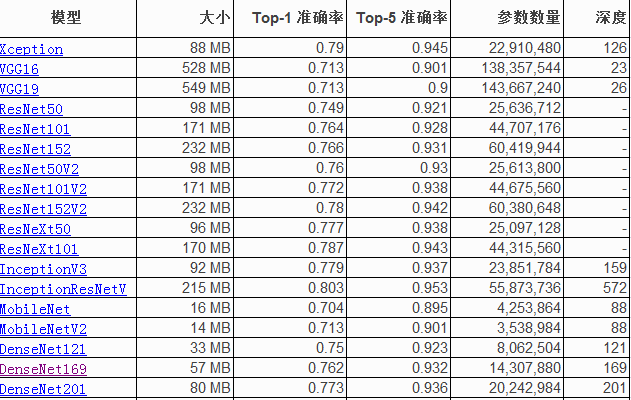

#### 18.2.2 使用VGG16预训练模型实现图像识别
常见的VGG网络有VGG16和VGG19, 顾名思义，就是指神经网络的层数。以下代码实现了模型的初始化定义。因VGG16预训练模型比较大，这里我们改为一个较小的模型DenseNet121。

(1)导入需要的模块

In [20]:
#导入所需模块
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.applications.densenet import preprocess_input,decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt

（2）加载预训练模型

In [27]:
# 在Keras的applications模块中导入VGG16模型
#from tensorflow.keras.applications.vgg16 import VGG16
#因VGG16预训练模型比较大（有528M）,这里我们改为一个较小的预训练模型DenseNet121，
#但其性能还更好
from keras.applications import densenet

#初始化DenseNet121模型
model = densenet.DenseNet121(weights='imagenet', include_top=True)

33193984/33188688 [==============================] - 1619s 49us/step


以上语句中，weights='imagenet'指定了使用ImageNet数据集的预训练模型；include_top=True则表示包含了DenseNet121模型最后的三个隐藏层，为了便于理解，我们来看一下当前的模型结构。

#### 18.2.3 导入数据
(1)导入数据

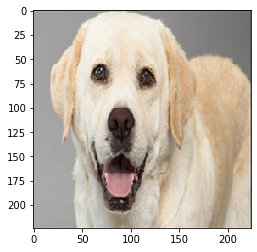

In [28]:
#导入图片，这图片是拉布拉多犬（Labrador ）
img_path = os.path.join("./data", "dog2.png")
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

（2）预处理图像

In [29]:
#预处理
x = image.img_to_array(img) #Image对象转换成numpy array对象
x = np.expand_dims(x, axis=0)#使用numpy数组函数扩充维度，(224, 224, 3)->(1, 224, 224, 3)
#预处理vgg16适合的输入形式，这与上面”model”中DenseNet121的预训练权重训练时相同的操作
x = preprocess_input(x)

（3）预测
利用预训练模型，对导入的图像进行预测

In [30]:
#预测
features = model.predict(x)
# 使用decode_predictions把预测结果翻译成容易读懂的形式(class, description, probability)
print('Predicted:', decode_predictions(features, top=3)[0])


40960/35363 [==================================] - 0s 3us/step
Predicted: [('n02099712', 'Labrador_retriever', 0.98875296), ('n02099601', 'golden_retriever', 0.008080285), ('n02104029', 'kuvasz', 0.001872947)]


这个预测结果还是很不错的！预测为Labrador的概率为0.99！

<mark style=background-color:red>延伸一下</mark> 
### 如何查看当前keras在使用GPU还是CPU?

In [21]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']